In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
from math import *
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, LassoCV, LassoLarsCV,Lasso
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# This notebook only shows the training process for maximum loading, process for minimum loading is similar

# Loading data

In [38]:
#loading the data
data=pd.read_csv('aggregate result.csv')
print('data size',data.shape)
print('small dataset, no complex models')

data size (322, 8)
small dataset, no complex models


##### creating columns : surface area and pellet_radius-hole_radius ratio

In [322]:
data

,Unnamed: 0,pellet_radius,hole_number,hole_radius,distance_from_centre,maximum_load,failure parameter at maximum_load,minimum_load,failure parameter at minimum_load
0,0,0.1,1,0.028,0.000,185249.485426,1.000043,185249.485426,1.000043
1,1,0.1,2,0.028,0.056,557932.248372,1.000053,62632.222516,1.000050
2,2,0.1,3,0.028,0.056,146069.059469,1.000096,51995.557123,1.000026
3,3,0.1,4,0.028,0.056,211321.832498,1.000077,52208.610010,1.000005


In [39]:
#creating columns: surface area and pellet_radius-hole_radius ratio

data['surface_area'] = [data['pellet_radius'][i]*2*np.pi+data['hole_number'][i]*data['hole_radius'][i]*2*np.pi for i in range(len(data))]
data['ratio pellet-hole'] = [data['pellet_radius'][i]/data['hole_radius'][i] for i in range(len(data))]

##### checking the correlation between maximum loading and other parameters

In [323]:
data.columns

Index(['Unnamed: 0', 'pellet_radius', 'hole_number', 'hole_radius',
       'distance_from_centre', 'maximum_load',
       'failure parameter at maximum_load', 'minimum_load',
       'failure parameter at minimum_load'],
      dtype='object')

In [308]:
# check the correlation
data_corr = data.corr()['maximum_load'].sort_values(ascending=False).drop(['maximum_load','minimum_load','failure parameter at maximum_load','failure parameter at maximum_load'])
data_corr

distance_from_centre                 0.050200
failure parameter at minimum_load    0.021407
hole_radius                          0.015683
ratio pellet-hole                   -0.031361
surface_area                        -0.567105
hole_number                         -0.687692
pellet_radius                             NaN
Name: maximum_load, dtype: float64

##### visualising the correlation

Index(['hole_number', 'hole_radius', 'distance_from_centre', 'maximum_load',
       'failure parameter at maximum_load', 'minimum_load',
       'failure parameter at minimum_load', 'surface_area',
       'ratio pellet-hole'],
      dtype='object')

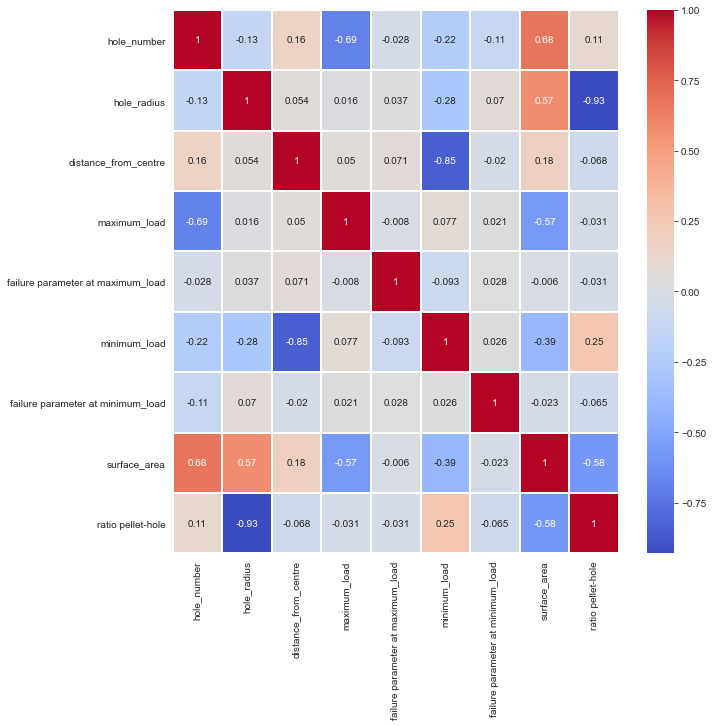

In [48]:
# most correlated features 
corrmat = data.corr()
#picking the top correlation features
top_corr_features = corrmat.index[abs(corrmat['maximum_load'])>0.0]
plt.figure(figsize=(10,10))
sns.heatmap(data[top_corr_features].corr(), cmap='coolwarm', annot=True, linewidths=2)
top_corr_features

##### selecting the potential useful columns

In [50]:
feature_names =  [ 'surface_area', 'hole_number','ratio pellet-hole','hole_radius','distance_from_centre']
X = data[feature_names]
y = data.maximum_load

##### overview of maximum load

In [51]:
#Descriptive statistics summary
data['maximum_load'].describe()

count       322.000000
mean     119609.925467
std       54456.847333
min       12640.427798
25%       76820.213224
50%      131922.347758
75%      163763.101751
max      214544.257417
Name: minimum_load, dtype: float64

d:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='maximum_load', ylabel='Density'>

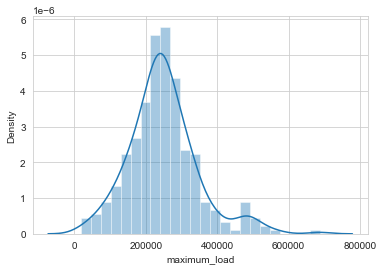

In [53]:
#histogram
sns.distplot(data['maximum_load'])

# Preprocessing data

In [60]:
# standarise the data or normalise,three methods
sc = StandardScaler()
mm = MinMaxScaler()
rb = RobustScaler()

In [168]:
#function to find the best method for standaise by cross validate the R2 score
def find_best_method(fit_list,model,X,y):
    train_X, val_X, train_y, val_y = train_test_split(X,y,random_state = 1)
    best_score = 0
    best_method = 0
    for method in fit_list:
        train_X = method.fit_transform(train_X)
        val_X = method.transform(val_X)
        model.fit(train_X, train_y)
        if model.score(val_X, val_y)>best_score:
            best_score=model.score(val_X, val_y)
            best_method=method
    return method

In [169]:
print('best method for Linear Regression:',find_best_method([sc,mm,rb],LinearRegression(),X,y))
print('best method for Ridge Regression:',find_best_method([sc,mm,rb],Ridge(),X,y))
print('best method for Lasso Regression:',find_best_method([sc,mm,rb],Lasso(),X,y))
print('Robust Scaler will be chosen')

best method for Linear Regression: RobustScaler()
best method for Ridge Regression: RobustScaler()
best method for Lasso Regression: RobustScaler()
Robust Scaler will be chosen


In [170]:
#create train and validation dataset
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state = 1)
train_X = rb.fit_transform(train_X)
val_X = rb.transform(val_X)

# Linear Model

##### quick application on the ordinary linear regression model

In [171]:
ln_model = LinearRegression()
ln_model.fit(train_X, train_y) 

LinearRegression()

In [172]:
# Predict
ln_val_predictions = ln_model.predict(val_X)
print('Validation r2_score:', r2_score(val_y,ln_val_predictions))

Validation r2_score: 0.42643483372479607


##### Searching alphas for the Ridge and Lasso Linear Regression 

In [317]:
model = RidgeCV(alphas=[1e-5,5e-5,1e-4, 5e-4, 1e-3, 5e-3,1e-2,5e-2,1e-1,5e-1,10,50,100,200,500,800],cv=40)
model.fit(train_X, train_y) 
print('best alpha for RidgeCV',model.alpha_)  
predicted = model.predict(train_X)
print('Validation r2_score:',model.score(val_X, val_y))

best alpha for RidgeCV 0.05
Validation r2_score: 0.45888069240810814


In [318]:
model = LassoCV(alphas=[1e-5,5e-5,1e-4, 5e-4, 1e-3, 5e-3,1e-2,5e-2,1e-1,5e-1,10,50,100,200,500,800],cv=40)
model.fit(train_X, train_y) 
print('best alpha for LassoCV',model.alpha_)  
predicted = model.predict(train_X)
print('Validation r2_score:',model.score(val_X, val_y))

best alpha for LassoCV 1e-05
Validation r2_score: 0.4264348731270876


In [319]:
model_lasso = Lasso(alpha=1e-5, max_iter=50000).fit(train_X, train_y)
model_ridge = Ridge(alpha=0.05, max_iter=50000).fit(train_X, train_y)
print('Ridge highest R2 score:',model_ridge.score(val_X, val_y))
print('Lasso highest R2 score:',model_lasso.score(val_X, val_y))

Ridge highest R2 score: 0.45888069240810814
Lasso highest R2 score: 0.4264348731270876


# Tree Model

##### Decision Tree

In [188]:
#split data, no need for standarisation
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state = 1)

In [189]:
# train model
decision_model = DecisionTreeRegressor()  
decision_model.fit(train_X, train_y) 

DecisionTreeRegressor()

In [190]:
# Predict
dt_val_predictions = decision_model.predict(val_X)
print('Decision Tree Validation r2_score:', decision_model.score(val_X, val_y))

Decision Tree Validation r2_score: 0.7369045791798894


##### Random Forest Quick application

In [209]:
forest_model = RandomForestRegressor()
forest_model.fit(train_X, train_y)
# Predict
rf_val_predictions = forest_model.predict(val_X)
print('Random Forest Validation r2_score:', r2_score(val_y,rf_val_predictions))

Random Forest Validation r2_score: 0.8044418273060324


##### Hyper-parameters tuning 

In [255]:
# Hyper parameter tuning
parameters = {
    'n_estimators':[10, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 4],
    'max_features':['auto', 'sqrt'],
    'bootstrap':[True, False]    
}

In [256]:
# Applying grid search and cross validation to tune the best parameters
gs_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameters,
                                cv=5,
                               verbose=2)

gs_cv.fit(train_X, train_y)

Fitting 5 folds for each of 4752 candidates, totalling 23760 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total 

KeyboardInterrupt: 

In [ ]:
# show the parameters 
gs_cv.best_params_

##### making predictions with the best parameters

In [307]:
max_forest_model =  RandomForestRegressor(
n_estimators=400,
min_samples_split= 5,
min_samples_leaf= 2,
max_features='auto',
max_depth=30,
bootstrap= True)
max_forest_model.fit(train_X, train_y)
# Predict
rf_val_predictions = max_forest_model.predict(val_X)
print('Random Forest Validation r2_score:', max_forest_model.score(val_X, val_y))

Random Forest Validation r2_score: 0.7948551936004369


##### Selecting the final model

In [244]:
my_model = forest_model

In [532]:
import pickle

max_model = "max_model.pkl"
# save
with open(max_model, 'wb') as file:
    pickle.dump(max_forest_model, file)